In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("..")

In [2]:
import pandas as pd
import torch
import torch.nn as nn
import timm
from torch import optim
from utils.ProgressBar import ProgressBar
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from DeepLearning.ApartmentsDatasetPyTorch import ApartmentsDatasetPyTorch
from tqdm import tqdm
from DeepLearning import PricePredictionModelV2
from DeepLearning.DataSubsetter import DataSubsetter

In [9]:
params = {
    "data_dir" : "../data2/data.csv",
    "images_dir" : '../data2/images',
    "img_input_size" : 256,
    "batch_size" : 64, # because we have a lot of columns
    "shuffle" : False,
    
    "inception_model_output_size" : 1024,
    "tabular_ffnn_output_size" : 256,
    "learning_rate" : 0.99e-3,
    "weight_decay" : 1e-3
}

In [10]:
gpu = torch.device("mps:0")

transform = transforms.Compose([
    transforms.Resize((params["img_input_size"], params["img_input_size"])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize images
])

subsetter = DataSubsetter(
    data_dir = params["data_dir"]
)

dataframe = subsetter.without(
    cols = ["coordinates", "latitude", "longitude"]
)

dataset = ApartmentsDatasetPyTorch(
    device = gpu,
    dataframe = dataframe,
    images_dir = params["images_dir"], 
    transform = transform
)
print("Tabular Size", len(dataset.df))
model = PricePredictionModelV2(
    dataset.tabular_data_size(), 
    params
)
model = model.to(gpu)
dataframe.head(1)

Tabular Size 1850
Inception output size 1024
Tabular output size 256
Regression input size 1280


,Unnamed: 0,source,id,price,area,rooms,floor,storeys,bathroom_count,new_building,...,L_kindergarten,L_hospital,building_type_Monolit,building_type_Other,building_type_Panel,building_type_Stone,condition_Good Condition,condition_Needs Renovation/Repair,condition_New/Excellent Condition,condition_Other
0,0,bars,4-3-1430,130000.0,60.5,2.0,3.0,13.0,1.0,1,...,0,0,0,1,0,0,0,1,0,0


# Training

In [11]:
dataset.df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1850 entries, 0 to 1849
Data columns (total 38 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Unnamed: 0                         1850 non-null   int64  
 1   source                             1850 non-null   object 
 2   id                                 1850 non-null   object 
 3   price                              1850 non-null   float64
 4   area                               1850 non-null   float64
 5   rooms                              1850 non-null   float64
 6   floor                              1850 non-null   float64
 7   storeys                            1850 non-null   float64
 8   bathroom_count                     1850 non-null   float64
 9   new_building                       1850 non-null   int64  
 10  F_Balcony                          1850 non-null   int64  
 11  F_Internet                         1850 non-null   int64

In [14]:
# Assuming 'dataset' is your full dataset
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
num_epochs = 20
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
num_GPU = 1

# def collate_fn(batch):
#     print(len(batch))
#     images, datas, prices = batch
#     return images, datas, prices

train_loader = DataLoader(
    train_dataset,
    batch_size=params["batch_size"], 
    shuffle=params["shuffle"]
)
val_loader = DataLoader(
    val_dataset,
    batch_size=params["batch_size"],
    shuffle=False
)
test_loader = DataLoader(
    test_dataset,
    batch_size=params["batch_size"], 
    shuffle=False
)

# Initialize lists to track losses
train_losses = []
val_losses = []

optimizer = optim.Adam(
    model.parameters(), 
    lr=params["learning_rate"],
    weight_decay = params["weight_decay"]
)
criterion = torch.nn.MSELoss()
criterion_abs = torch.nn.L1Loss()
criterion = criterion_abs

print("Starting training...")
# Training loop with progress bar
for epoch in range(num_epochs):
    # Training
    model.train()  # Set the model to training mode
    running_loss = 0.0
    l1_losses = []
    for data in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Training'):
        images, datas, prices = data
        optimizer.zero_grad()
        outputs = model(images, datas)
        prices_viewed = prices.view(-1, 1).float()
        loss = criterion(outputs, prices_viewed)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))  # Average loss for this epoch

    # Validation
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():  # Disable gradient calculation
        for data in tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Validation'):
            images, datas, prices = data
            outputs = model(images, datas)  # Forward pass
            prices_viewed = prices.view(-1, 1).float()
            loss = criterion(outputs, prices_viewed)  # Compute loss
            val_loss += loss.item()  # Accumulate the loss
            l1_losses.append(criterion_abs(outputs, prices_viewed))
        
    val_losses.append(val_loss / len(val_loader))  # Average loss for this epoch
    l1_mean_loss = sum(l1_losses) / len(l1_losses)
    # Print epoch's summary
    print(f'Epoch {epoch+1}, Training Loss: {int(train_losses[-1])}, Validation Loss: {int(val_losses[-1])}, L1: {l1_mean_loss}')


Starting training...


Epoch 1/20 - Validation: 100%|██████████████████| 65/65 [01:44<00:00,  1.60s/it]


Epoch 1, Training Loss: 67400, Validation Loss: 58587, L1: 58587.75390625


Epoch 2/20 - Validation: 100%|██████████████████| 65/65 [01:43<00:00,  1.60s/it]


Epoch 2, Training Loss: 64643, Validation Loss: 55125, L1: 55125.6328125


Epoch 3/20 - Validation: 100%|██████████████████| 65/65 [01:44<00:00,  1.60s/it]


Epoch 3, Training Loss: 62325, Validation Loss: 54324, L1: 54324.296875


Epoch 4/20 - Validation: 100%|██████████████████| 65/65 [01:44<00:00,  1.60s/it]


Epoch 4, Training Loss: 59911, Validation Loss: 52008, L1: 52008.078125


Epoch 5/20 - Validation: 100%|██████████████████| 65/65 [01:43<00:00,  1.59s/it]


Epoch 5, Training Loss: 58148, Validation Loss: 55806, L1: 55806.08203125


Epoch 6/20 - Validation: 100%|██████████████████| 65/65 [01:43<00:00,  1.59s/it]


Epoch 6, Training Loss: 56771, Validation Loss: 50750, L1: 50750.80859375


Epoch 7/20 - Validation: 100%|██████████████████| 65/65 [01:42<00:00,  1.58s/it]


Epoch 7, Training Loss: 55387, Validation Loss: 56541, L1: 56541.6328125


Epoch 8/20 - Validation: 100%|██████████████████| 65/65 [01:43<00:00,  1.59s/it]


Epoch 8, Training Loss: 54266, Validation Loss: 60182, L1: 60182.1875


Epoch 9/20 - Validation: 100%|██████████████████| 65/65 [01:43<00:00,  1.59s/it]


Epoch 9, Training Loss: 53855, Validation Loss: 49672, L1: 49672.875


Epoch 10/20 - Validation: 100%|█████████████████| 65/65 [01:42<00:00,  1.58s/it]


Epoch 10, Training Loss: 52641, Validation Loss: 65415, L1: 65415.76953125


Epoch 11/20 - Training:  11%|██                | 34/300 [00:56<07:23,  1.67s/it]


KeyboardInterrupt: 

In [25]:
torch.save(model, "../models/model_v2.pth")

In [ ]:
# !conda install --yes pytorch torchvision -c pytorch

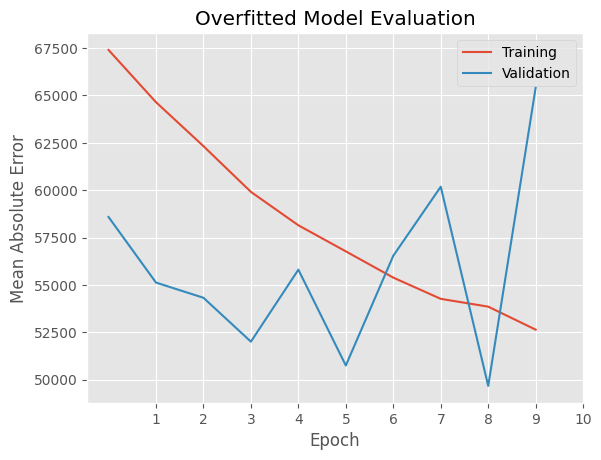

In [23]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.title("Overfitted Model Evaluation")
plt.plot(train_losses, label = 'Training')
plt.plot(val_losses, label = 'Validation')
plt.ylabel("Mean Absolute Error")
plt.xlabel("Epoch")
plt.xticks(range(1, 11))
plt.legend()

plt.savefig('../visualizations/dl_model_with_images.png', dpi = 800)
plt.show()

In [29]:
def count_neurons_and_weights(model):
    total_neurons = 0
    total_weights = 0

    for layer in model.modules():
        if isinstance(layer, nn.Linear):
            # Neurons in the layer
            total_neurons += layer.out_features

            # Weights and biases
            total_weights += torch.numel(layer.weight) + torch.numel(layer.bias)

    return total_neurons, total_weights

# Create an instance of your model
params = {"inception_model_output_size": 100, "tabular_ffnn_output_size": 50}  # Example parameters

# Calculate the statistics
neurons, weights = count_neurons_and_weights(model)
print(f"Total Neurons: {neurons}, Total Weights: {weights}")


Total Neurons: 11649, Total Weights: 22044161
